In [1]:
import os
os.environ['SETIGEN_ENABLE_GPU'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from astropy import units as u
import blimpy as bl

import setigen as stg

bshuf filter already loaded, skip it.
zfp filter already loaded, skip it.


# Raw File Generation

In [5]:
sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches


**num_taps (int, optional) – Number of PFB taps**<br>
**num_branches (int, optional) – Number of PFB branches. Note that this results in num_branches / 2 coarse channels.**<br>
num_branches is the FFT length for the real FFT, so that there are a resultant num_branches / 2 coarse channels possible to record.

fch1 to fch1 +/- sample_rate / 2


In [32]:
antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=6*u.GHz,
                              ascending=True,
                              num_pols=1)


In [16]:
antenna.streams

**ascending : Default is True, for which fch1 is the minimum frequency.**

In [33]:
antenna.x.add_noise(v_mean=0, 
                    v_std=1)

# antenna.y.add_noise(v_mean=0, 
#                     v_std=1)


In [75]:
'''print(antenna.get_samples(5))
#print(antenna.x.get_samples(5))
#print(antenna.y.get_samples(5))
'''


'print(antenna.get_samples(5))\n#print(antenna.x.get_samples(5))\n#print(antenna.y.get_samples(5))\n'

In [34]:
antenna.x.add_constant_signal(f_start=6002.2e6, 
                              drift_rate=-2*u.Hz/u.s, 
                              level=0.2)

# antenna.y.add_constant_signal(f_start=6002.2e6, 
#                               drift_rate=-2*u.Hz/u.s, 
#                               level=0.2,
#                               phase=np.pi/2)

In [35]:
digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_fwhm=32,
                                           num_bits=8)

rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=0,
                                    num_chans=64,
                                    block_size=134217728,
                                    blocks_per_file=128,
                                    num_subblocks=128)



num_subblocks:  Number of partitions per block, used for computation. <br>
32: 80000
128: 2400MB<br>

If `num_subblocks`=1, one block's worth of data will be passed through the pipeline and recorded at once.

assert self.block_size % int(self.num_antennas * self.num_chans * self.num_taps * self.bytes_per_sample) == 0

rvb.block_size % int(rvb.num_antennas * rvb.num_chans * rvb.num_taps * rvb.bytes_per_sample) == 0

In [36]:
print(rvb.num_antennas , rvb.num_chans , rvb.num_taps , rvb.bytes_per_sample)


1 64 8 2


In [28]:
filterbank.

In [37]:
rvb.record(output_file_stem='syn_2',
           num_blocks=2, 
           length_mode='num_blocks',
           header_dict={'HELLO': 'test_value',
                        'TELESCOP': 'GBT'},
           verbose=False)

Blocks: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:14<00:00,  7.27s/it]


In [38]:
!rawspec -f 1024 -t 4 -d . syn_2


working stem: syn_2
opening file: syn_2.0000.raw
opening file: syn_2.0001.raw [No such file or directory]
output product 0: 512 spectra


rawspec reads GUPPI RAW files and produces integrated power spectra. Up to 4 different output products with various channelization/integration combinations can be created at one time. Output products can either be total power (aka Stokes I) or full cross polarization spectra. Currently, rawspec outputs to SIGPROC Filterbank files, see http://sigproc.sourceforge.net. It can also output the spectral data as UDP packets to a remote receiver. Each such UDP packet is a small, self-contained Filterbank "file".

-d, --dest=DEST        Destination directory or host:port<br>
  -f, --ffts=N1[,N2...]  FFT lengths [1048576, 8, 1024]<br>
  -g, --GPU=IDX          Select GPU device to use [0]<br>
  -H, --hdrs             Save headers to separate file<br>
  -n, --nchan=N          Number of coarse channels to process [all]<br>
  -o, --outidx=N         First index number for output files [0]<br>
  -p  --pols={1|4}[,...] Number of output polarizations [1]<br>
                         1=total power, 4=cross pols, -4=full stokes<br>
  -r, --rate=GBPS        Desired net data rate in Gbps [6.0]<br>
  -s, --schan=C          First coarse channel to process [0]<br>
  -t, --ints=N1[,N2...]  Spectra to integrate [51, 128, 3072]<br>


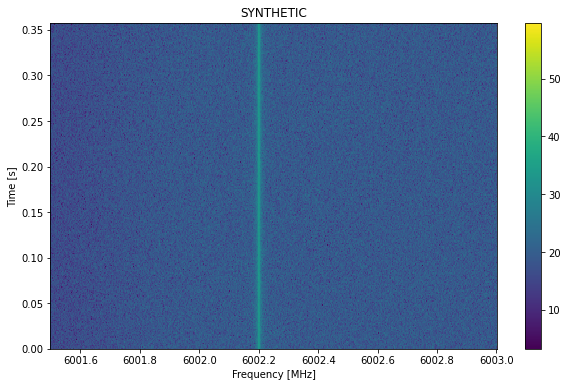

In [20]:
%matplotlib inline
wf = bl.Waterfall('syn_1.rawspec.0000.fil',
                  f_start=6001.5,
                  f_stop=6003.0)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

In [31]:
len(wf.data)

128

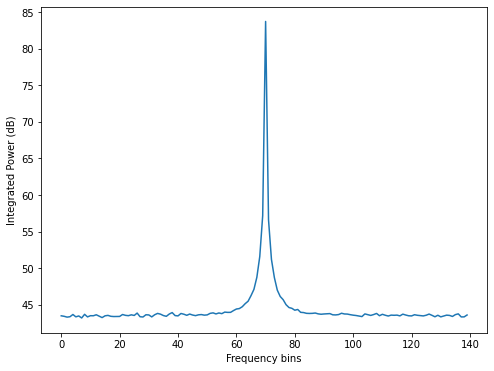

In [32]:
type(wf.data)
# Viewing data in dB
x = stg.db(np.sum(wf.data[:, 0, :], axis=0))

plt.figure(figsize=(8, 6))
plt.plot(x)
plt.xlabel('Frequency bins')
plt.ylabel('Integrated Power (dB)')
plt.show()



# Detecting signals from existing guppi raw

In [5]:
start_chan = 0
input_file_stem = 'syn_1'

raw_params = stg.voltage.get_raw_params(input_file_stem=input_file_stem,
                                        start_chan=start_chan)

antenna = stg.voltage.Antenna(sample_rate=sample_rate,
                              **raw_params)

In [14]:
start_chan = 0
input_file_stem = 'syn_1'

raw_params = stg.voltage.get_raw_params(input_file_stem=input_file_stem,
                                        start_chan=start_chan)

antenna = stg.voltage.Antenna(sample_rate=2*raw_params['chan_bw'],
                              **raw_params)

In [14]:
raw_params

{'num_bits': 8,
 'chan_bw': 2929687.5,
 'ascending': True,
 'num_pols': 1,
 'block_size': 134217728,
 'obs_length': 0.3579139413333333,
 'tbin': 3.41333333333333e-07,
 'num_antennas': 1,
 'num_chans': 64,
 'center_freq': 6092285156.25,
 'fch1': 6000000000.0}

In [15]:
filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

rvb = stg.voltage.RawVoltageBackend.from_data(input_file_stem=input_file_stem,
                                              antenna_source=antenna,
                                              filterbank=filterbank,
                                              start_chan=start_chan,
                                              num_subblocks=128)

If the signal is non-drifting, in general the spectral response will go as 1/sinc^2(x), where x is the fractional error off of the center of the spectral bin. To calculate the corresponding amount to adjust signal_level, you can use stg.voltage.get_leakage_factor(f_start, raw_voltage_backend, fftlength). This technically calculates 1/sinc(x), which is inherently squared naturally along with the cosine signal amplitude during fine channelization.<br>

level = stream.get_total_noise_std() * leakage_factor * signal_level<br>

 filterbank data products are powers, the final signal strength goes as the square of the initial amplitude (e.g. level). Then, there are scaling factors due to the rFFT in the polyphase filterbank and the FFT in the fine channelization step. If there is a time integration, that must be accounted for in the initial amplitude. Most of these effects are calculated using stg.voltage.get_level:

In [16]:
fftlength = 1024
signal_level = stg.voltage.get_level(snr=15,
                                     raw_voltage_backend=rvb,
                                     fftlength=fftlength,
                                     num_blocks=1,
                                     length_mode='num_blocks')

for f_start in np.linspace(6003.1e6, 6003.8e6, 5):
    leakage_factor = stg.voltage.get_leakage_factor(f_start, rvb, fftlength)
    print(f'{f_start/1e6:.4f} MHz leakage factor: {leakage_factor:.3f}')
    
    for stream in antenna.streams:
        # There's actually no noise present, but we set levels assuming a background noise_std of 1
        level = 1 * leakage_factor * signal_level
        stream.add_constant_signal(f_start=f_start, 
                                   drift_rate=0*u.Hz/u.s, 
                                   level=level)

rvb.record(output_file_stem='syn_1_from_data_sample_rate_calculated',
           num_blocks=1, 
           length_mode='num_blocks',
           header_dict={'TELESCOP': 'GBT'},
           digitize=False,
           verbose=False)

!rawspec -f 1024 -t 4 -d . syn_1_from_data_sample_rate_calculated

6003.1000 MHz leakage factor: 1.304
6003.2750 MHz leakage factor: 1.010
6003.4500 MHz leakage factor: 1.434
6003.6250 MHz leakage factor: 1.001
6003.8000 MHz leakage factor: 1.536


Blocks: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.30s/it]


working stem: syn_1_from_data_sample_rate_calculated
opening file: syn_1_from_data_sample_rate_calculated.0000.raw
opening file: syn_1_from_data_sample_rate_calculated.0001.raw [No such file or directory]
output product 0: 256 spectra


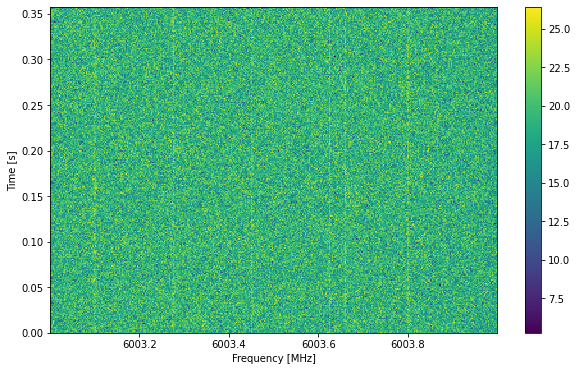

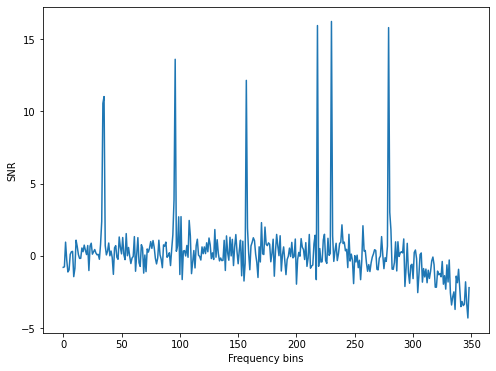

In [22]:
%matplotlib inline 
wf = bl.Waterfall(#'syn_1_from_data_sample_rate_calculated.rawspec.0000.fil',
                  'syn_1_from_data.rawspec.0000.fil',
                    f_start=6003.0,
                  f_stop=6004.0)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spectrum = stg.integrate(frame, normalize=True)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()

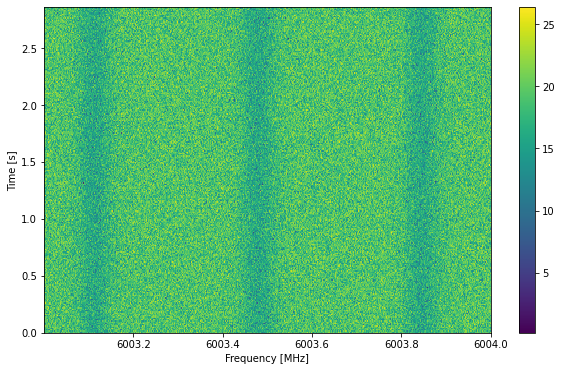

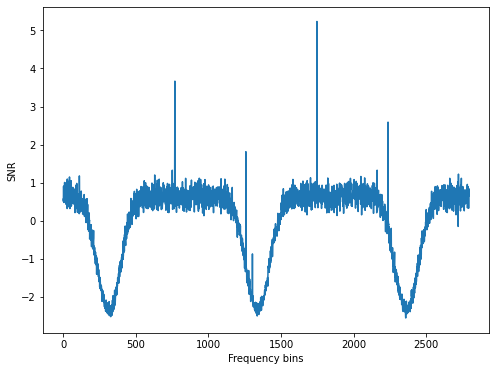

In [11]:
%matplotlib inline 
wf = bl.Waterfall('syn_1_from_data_sample_rate_calculated.rawspec.0000.fil',
                  #'syn_1_from_data.rawspec.0000.fil',f_start=6003.0,
                  f_start=6003.0,
                  f_stop=6004.0)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spectrum = stg.integrate(frame, normalize=True)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()

### turbo_SETI

In [27]:
import os
import glob
import time 
# 3rd party packages
import pylab as plt
from blimpy import Waterfall
import turbo_seti.find_doppler.seti_event as turbo
import turbo_seti.find_event as find
from turbo_seti.find_doppler.find_doppler import FindDoppler
from turbo_seti.find_event.find_event_pipeline import find_event_pipeline
from turbo_seti.find_event.plot_event_pipeline import plot_event_pipeline

In [40]:
data_directory='/home/eakshay/setigen/' #syn_1_from_data.rawspec.0000.fil
op_directory='/home/eakshay/setigen/turbo/'

In [1]:
#os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
!fil2h5 syn_1_from_data.rawspec.0000.fil

bshuf filter already loaded, skip it.
zfp filter already loaded, skip it.
blimpy.waterfall INFO     Detecting intermediate frequency and time resolution data.
blimpy.waterfall INFO     __write_to_hdf5_heavy: For ./syn_1_from_data.rawspec.0000.h5, chunk_dim=(10, 1, 65536), blob_dim=(256, 1, 65536), n_blobs=1
blimpy.waterfall ERROR    __write_to_hdf5_heavy: Writing the output HDF5 file ./syn_1_from_data.rawspec.0000.h5 failed!
OSError(37, "Unable to create file (unable to lock file, errno = 37, error message = 'No locks available')")
blimpy.waterfall INFO     __write_to_hdf5_heavy: Removal of partial HDF5 file ./syn_1_from_data.rawspec.0000.h5 succeeded.


In [41]:
h5_list = (glob.glob(os.path.join(data_directory,'*.fil')))
print(h5_list)
#print(len(h5_list))

h5_list_path = os.path.join(op_directory,'h5_files.lst')
print(h5_list_path)

with open(h5_list_path, 'w') as f:
    for h in h5_list:
        f.write(h + '\n')
        
with open(h5_list_path, 'r') as f:
    print(f.read())



['/home/eakshay/setigen/syn_1.rawspec.0000.fil', '/home/eakshay/setigen/syn_2.rawspec.0000.fil', '/home/eakshay/setigen/syn_1_from_data.rawspec.0000.fil']
/home/eakshay/setigen/turbo/h5_files.lst
/home/eakshay/setigen/syn_1.rawspec.0000.fil
/home/eakshay/setigen/syn_2.rawspec.0000.fil
/home/eakshay/setigen/syn_1_from_data.rawspec.0000.fil



In [42]:
for file in h5_list:
    doppler = FindDoppler(file,
                      max_drift = 3, # Max drift rate = 4 Hz/second
                      snr = 10,      # Minimum signal to noise ratio = 10:1
                      out_dir = op_directory # This is where the turboSETI output files will be stored.
                     )
    doppler.search()


turbo_seti version 2.1.18
blimpy version 2.0.32
h5py version 3.6.0

data_handler    INFO     Filterbank file detected. Attempting to create .h5 file in current directory...
blimpy.waterfall INFO     Detecting intermediate frequency and time resolution data.
blimpy.waterfall INFO     __write_to_hdf5_heavy: For /home/eakshay/setigen/turbo/syn_1.rawspec.0000.h5, chunk_dim=(10, 1, 65536), blob_dim=(256, 1, 65536), n_blobs=1
blimpy.waterfall ERROR    __write_to_hdf5_heavy: Writing the output HDF5 file /home/eakshay/setigen/turbo/syn_1.rawspec.0000.h5 failed!
OSError(37, "Unable to create file (unable to lock file, errno = 37, error message = 'No locks available')")
blimpy.waterfall INFO     __write_to_hdf5_heavy: Removal of partial HDF5 file /home/eakshay/setigen/turbo/syn_1.rawspec.0000.h5 succeeded.
root            ERROR    Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/home/eakshay/.local/lib/pyt

TypeError: object of type 'NoneType' has no len()

In [45]:
import numpy as np
import h5py

d1 = np.random.random(size = (1000,20))
d2 = np.random.random(size = (1000,200))

hf = h5py.File('data.h5', 'w')
hf.create_dataset('dataset_1', data=d1)
hf.create_dataset('dataset_2', data=d2)

OSError: [Errno 37] Unable to create file (unable to lock file, errno = 37, error message = 'No locks available')

# backend

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import cupy as xp
except ImportError:
    import numpy as xp
import numpy as np

from astropy import units as u
import blimpy as bl

import setigen as stg

def get_numpy(v):
    try:
        return xp.asnumpy(v)
    except AttributeError:
        return v
    
def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)


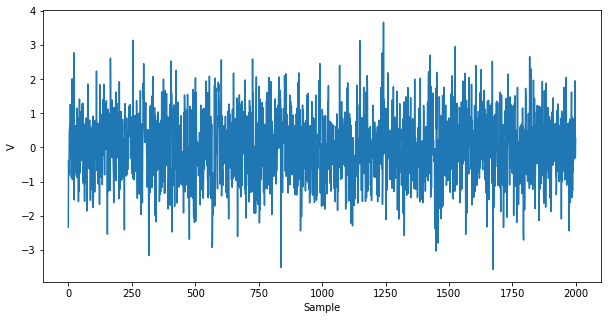

In [36]:
antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=0*u.GHz,
                              ascending=True,
                              num_pols=1)

antenna.x.add_noise(v_mean=0, 
                    v_std=1)

v = antenna.x.get_samples(2000)
    
plt.figure(figsize=(10, 5))
plt.plot(get_numpy(v))
plt.xlabel('Sample')
plt.ylabel('V')
plt.show()


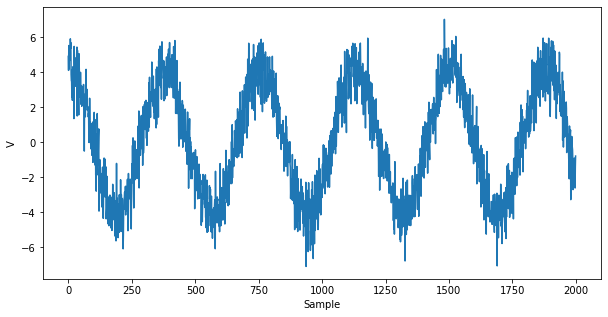

In [48]:
antenna.x.add_constant_signal(f_start=8e6, 
                              drift_rate=-2*u.Hz/u.s, 
                              level=0.5)
antenna.x.add_constant_signal(f_start=8.1e6, 
                              drift_rate=-4*u.Hz/u.s, 
                              level=0.2)

v = get_numpy(antenna.x.get_samples(2000))
    
plt.figure(figsize=(10, 5))
plt.plot(get_numpy(v))
plt.xlabel('Sample')
plt.ylabel('V')
plt.show()

# Custom signal

In [ ]:
sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_fwhm=32,
                                           num_bits=8)

In [ ]:
antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=6*u.GHz,
                              ascending=True,
                              num_pols=1)




In [5]:
antenna.x.add_noise(0, 1)

## Adding quadratic signal

In [6]:
try:
    from cusignal import chirp
except ImportError:
    from scipy.signal import chirp

def my_signal(ts):
    return 0.004 * chirp(t=ts,
                         f0=6002.2e6,
                         t1=rvb.time_per_block,
                         f1=6002.3e6,
                         method='quadratic')

# def my_signal_2(ts):
#     return 0.004 * chirp(t=ts,
#                          f0=6002.4e6,
#                          t1=rvb.time_per_block,
#                          f1=6002.3e6,
#                          method='logarithmic')

# def my_signal_3(ts):
#     return 0.004 * chirp(t=ts,
#                          f0=6002.6e6,
#                          t1=rvb.time_per_block,
#                          f1=6002.3e6,
#                          method='hyperbolic')

antenna.x.add_signal(my_signal)
#antenna.x.add_signal(my_signal_2)
#antenna.x.add_signal(my_signal_3)
antenna.x.add_constant_signal(f_start=6002.0e6, drift_rate=-2*u.Hz/u.s, level=0.2)

There are two modes to record, num_blocks and obs_length. The former allows you to specify how many data blocks to record, as defined by the RAW format, and the latter computes the number of required blocks from the desired observation length (in seconds). The header_dict parameter allows for overwriting existing header values / adding additional keywords. For example, TurboSETI requires the TELESCOP parameter to be set to "GBT" to run on certain types of RAW files, so you can overwrite this parameter using header_dict.

raw_file_stem is the path + prefix for your saved GUPPI RAW file.

In [7]:
rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=0,
                                    num_chans=64,
                                    block_size=134217728,
                                    blocks_per_file=128,
                                    num_subblocks=32)



In [8]:
rvb.record(output_file_stem='example1_custom_signal',
           num_blocks=1, 
           length_mode='num_blocks',
           header_dict={'HELLO': 'test_value',
                        'TELESCOPE': 'GBT'},
          verbose=False
          )


Blocks:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s]


TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

In [ ]:
!rawspec -f 1024 -t 16 -d example_custom_signal

In [ ]:
wf = bl.Waterfall('example_custom_signal.rawspec.0000.fil',
                  f_start=6001.0,
                  f_stop=6003.0)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()